In [151]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

#import missingno as msno
#import squarify
#import eli5
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from scipy.sparse import hstack
from sklearn.model_selection import cross_validate
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

from operator import itemgetter


from sklearn import linear_model

import keras
import theano
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

sns.set(color_codes=True)
%matplotlib inline

In [3]:
wine_150k = pd.read_csv('data/winemag-data_first150k.csv',index_col=0)
wine_130k = pd.read_csv('data/winemag-data-130k-v2.csv',index_col=0)

wine_reviews_master = pd.concat([wine_150k,wine_130k],axis=0)
wine_reviews_master.reset_index(drop=True, inplace=True)

In [4]:
wine_reviews_master.shape

(280901, 13)

In [5]:
wine_reviews_master.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [6]:
wine_reviews_master.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,NaN,NaN,NaN,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,NaN,NaN,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,NaN,NaN,NaN,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,NaN,NaN,NaN,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,NaN,NaN,NaN,Provence red blend,Domaine de la Bégude


In [7]:
wine_reviews_master.drop_duplicates('description').shape

(169430, 13)

Looks like we have a few duplicate rows, let's drop them.

In [8]:
wine_reviews_master = wine_reviews_master.drop_duplicates('description')

In [9]:
wine_reviews_master.isnull().sum()

country                      60
description                   0
designation               50067
points                        0
price                     12821
province                     60
region_1                  27913
region_2                 101914
taster_name              107076
taster_twitter_handle    110139
title                     97821
variety                       1
winery                        0
dtype: int64

We are going to drop the null price columns though, as there are far too many to manually fill in. I'm actually going to keep them in a seperate data point and we can use predict these prices later (even though we won't know if they are correct).

In [10]:
wine_reviews = wine_reviews_master.dropna(subset=['price'])
wine_reviews = wine_reviews_master.dropna(subset=['country'])

wine_reviews_no_price = wine_reviews_master[wine_reviews_master.price.isnull()]

In [11]:
wine_reviews.isnull().sum()

country                       0
description                   0
designation               50057
points                        0
price                     12817
province                      0
region_1                  27853
region_2                 101854
taster_name              107073
taster_twitter_handle    110136
title                     97818
variety                       1
winery                        0
dtype: int64

Most of our data has a type of "object", so `.describe()` won't be extremely useful, but we can still see the max score and price.

In [12]:
wine_reviews.describe()

,points,price
count,169370.000000,156553.000000
mean,88.243101,34.645711
std,3.145058,39.385159
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,3300.000000


Let's answer some basic questions we might have about the data.

+ Most expensive
+ Least expensive
+ Where do a majority of wines in the dataset come from?
+ Perfect wines
+ Worst wine
+ Best wine country
+ Avg wine score countries

In [13]:
most_expensive = wine_reviews.loc[[wine_reviews['price'].idxmax()]]
most_expensive

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
231220,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet


In [14]:
least_expensive = wine_reviews.loc[[wine_reviews['price'].idxmin()]]
least_expensive

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1858,US,"Sweet and fruity, this canned wine feels soft ...",Unoaked,83,4.0,California,California,California Other,NaN,NaN,NaN,Chardonnay,Pam's Cuties


In [15]:
wine_reviews.country.value_counts()

US                        70840
France                    27161
Italy                     24990
Spain                      8811
Portugal                   6913
Chile                      6132
Argentina                  5463
Australia                  4390
Austria                    3963
Germany                    2795
New Zealand                2592
South Africa               2194
Greece                      740
Israel                      595
Canada                      274
Hungary                     210
Romania                     156
Bulgaria                    151
Uruguay                     141
Croatia                      94
Slovenia                     92
Mexico                       89
Turkey                       88
Georgia                      86
Moldova                      77
England                      64
Brazil                       57
Lebanon                      42
Morocco                      26
Cyprus                       19
Macedonia                    18
Ukraine 

In [16]:
perfect_wines =wine_reviews[wine_reviews['points']==100] #wines with a perfect score
perfect_wines[['country', 'price', 'province', 'variety', 'winery']].sort_values(by=['price'], ascending=False)

,country,price,province,variety,winery
262685,France,1500.0,Bordeaux,Bordeaux-style Red Blend,Château Cheval Blanc
262683,France,1500.0,Bordeaux,Bordeaux-style Red Blend,Château Lafite Rothschild
26296,France,1400.0,Champagne,Chardonnay,Krug
2145,France,848.0,Bordeaux,Bordeaux-style White Blend,Château Haut-Brion
265902,Portugal,650.0,Port,Port,Quinta do Noval
240659,France,617.0,Champagne,Chardonnay,Salon
196711,Italy,550.0,Tuscany,Sangiovese,Biondi Santi
24151,Italy,460.0,Tuscany,Merlot,Tenuta dell'Ornellaia
268988,US,450.0,California,Bordeaux-style Red Blend,Verité
193127,Portugal,450.0,Douro,Portuguese Red,Casa Ferreirinha


In [17]:
perfect_wines.shape

(26, 13)

In [18]:
perfect_wines.price.mean()

452.03846153846155

There are 26 wines in the dataset given a perfect score, the average cost is \$452.04, but this ranges from \$65 to  \$1500. The lowest scores in the dataset are 80, so let's look at how many are at that end of the spectrum.

In [19]:
worst_wines =wine_reviews[wine_reviews['points']==80] #wines with a perfect score
worst_wines[['country', 'price', 'province', 'variety', 'winery']].sort_values(by=['price'], ascending=False)

,country,price,province,variety,winery
127602,US,80.0,California,Syrah,Parsonage Village
60659,US,79.0,California,Red Blend,Sextant
135132,Argentina,72.0,Mendoza Province,Sauvignon Blanc,Weinert
254919,US,69.0,California,Zinfandel,Grgich Hills
63758,US,65.0,California,Cabernet Sauvignon,Tara Bella
64624,US,55.0,California,Zinfandel,Rosenblum
57192,US,55.0,California,Red Blend,Millésimé
127604,US,54.0,California,Cabernet Sauvignon,Grasso
135140,Portugal,50.0,Port,Port,Quinta das Heredias
273347,US,45.0,California,Red Blend,Casa Tiene Vista


In [20]:
worst_wines.price.describe()

count    745.000000
mean      16.931544
std        9.744416
min        5.000000
25%       10.000000
50%       14.000000
75%       20.000000
max       80.000000
Name: price, dtype: float64

There are a lot more wines with an 80 rating than 100, which is expected. They have an average price of \$17 with a range from \$5 on up to \$80.

# DO THIS

### What makes a great wine?

Are there any words that show up more often in the description of our 100 point wines, than our 80 point ones?

+ token words
+ count em up

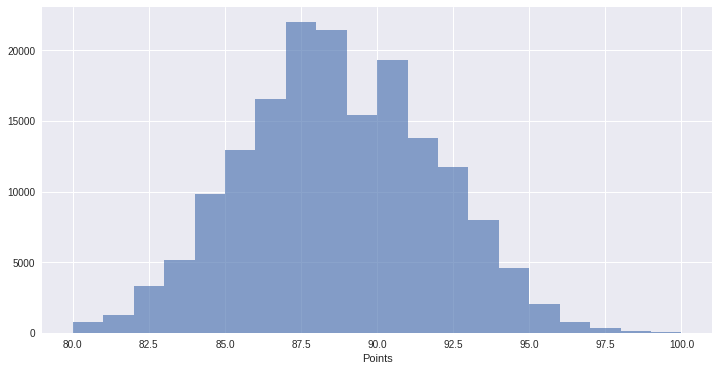

In [21]:
plt.figure(figsize=(12,6))
wine_reviews['points'].hist(bins=20, alpha=.65)
plt.xlabel('Points');

In [22]:
len(wine_reviews.price.unique())

416

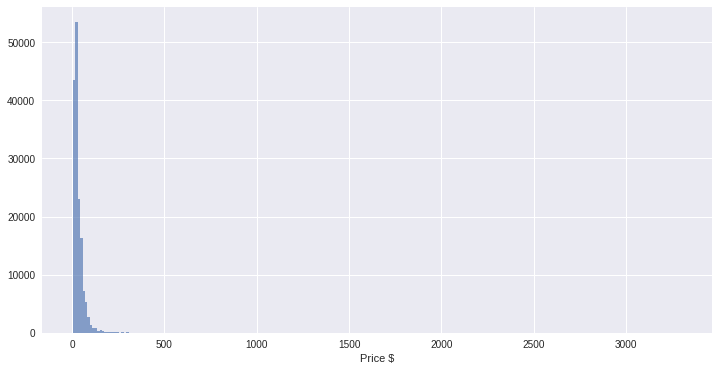

In [23]:
plt.figure(figsize=(12,6))
wine_reviews['price'].hist(bins=250, alpha=.65)
plt.xlabel('Price $');

In [24]:
wines_by_country = pd.DataFrame(wine_reviews.groupby('country')['points','price'].mean())
wines_by_country = wines_by_country.assign(num_of_wines = wine_reviews.groupby('country')['description'].count())

In [25]:
wines_by_country.describe()

,points,price,num_of_wines
count,50.000000,48.000000,50.000000
mean,86.833831,25.433704,3387.400000
std,2.029335,11.782803,11116.395373
min,81.500000,9.882353,1.000000
25%,85.655449,15.976589,7.250000
50%,87.077552,23.819930,70.500000
75%,88.159214,30.476437,703.750000
max,91.750000,65.142857,70840.000000


Let's drop any countries with less than 20 wines in the dataset, but before we do, let's look at what those countries are. 

In [26]:
wines_by_country[wines_by_country['num_of_wines']<20]

,points,price,num_of_wines
country,,,
Albania,88.000000,20.000000,1
Armenia,87.500000,14.500000,2
Bosnia and Herzegovina,85.333333,12.666667,3
China,84.333333,17.333333,3
Cyprus,86.315789,15.789474,19
Czech Republic,86.857143,21.142857,14
Egypt,83.666667,NaN,3
India,89.333333,14.444444,9
Japan,85.000000,24.000000,1


In [27]:
wines_by_country = wines_by_country[wines_by_country['num_of_wines']>20]

In [28]:
wines_by_country.reset_index(inplace=True)

In [29]:
wines_by_country

,country,points,price,num_of_wines
0,Argentina,86.451400,23.137440,5463
1,Australia,88.138952,32.771190,4390
2,Austria,89.932879,31.627165,3963
3,Brazil,84.421053,23.730769,57
4,Bulgaria,87.496689,14.443709,151
5,Canada,89.127737,35.466912,274
6,Chile,86.353066,20.121991,6132
7,Croatia,87.042553,24.494505,94
8,England,91.750000,52.633333,64
9,France,88.868635,42.713897,27161


Let's take a look at the top 5 and bottom 5 wine countries by score.

In [30]:
wines_by_country.points.nlargest(5)

8     91.750000
2     89.932879
11    89.324866
5     89.127737
9     88.868635
Name: points, dtype: float64

In [31]:
wines_by_country.points.nsmallest(5)

3     84.421053
17    85.224719
22    85.596154
28    85.872340
18    86.038961
Name: points, dtype: float64

In [32]:
country_order = list(wines_by_country.sort_values(by='num_of_wines', ascending=False).country)

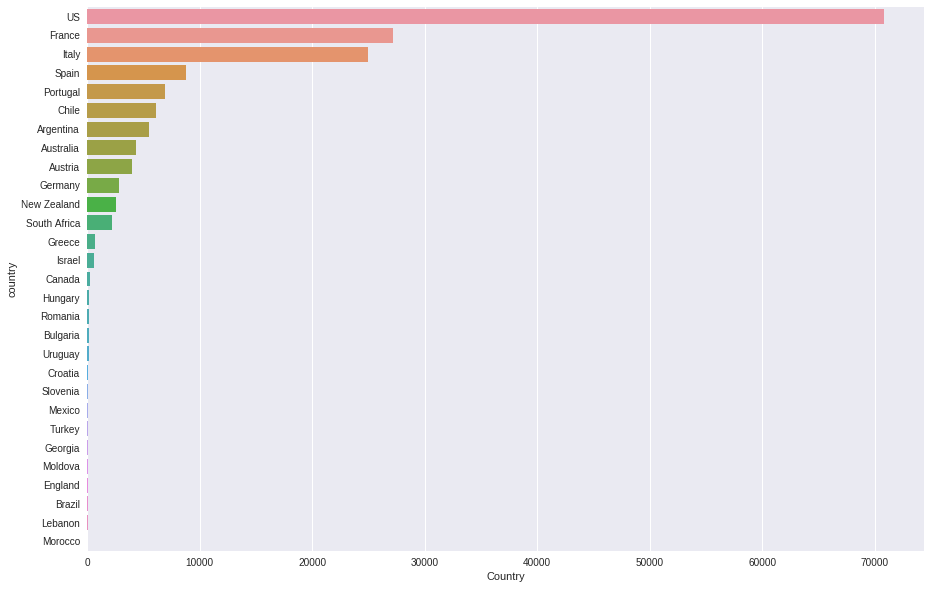

In [33]:
plt.figure(figsize=(15,10))
sns.barplot(x='num_of_wines', y='country', data=wines_by_country, orient='h', order = country_order);
plt.xlabel('Number of Wines')
plt.xlabel('Country');

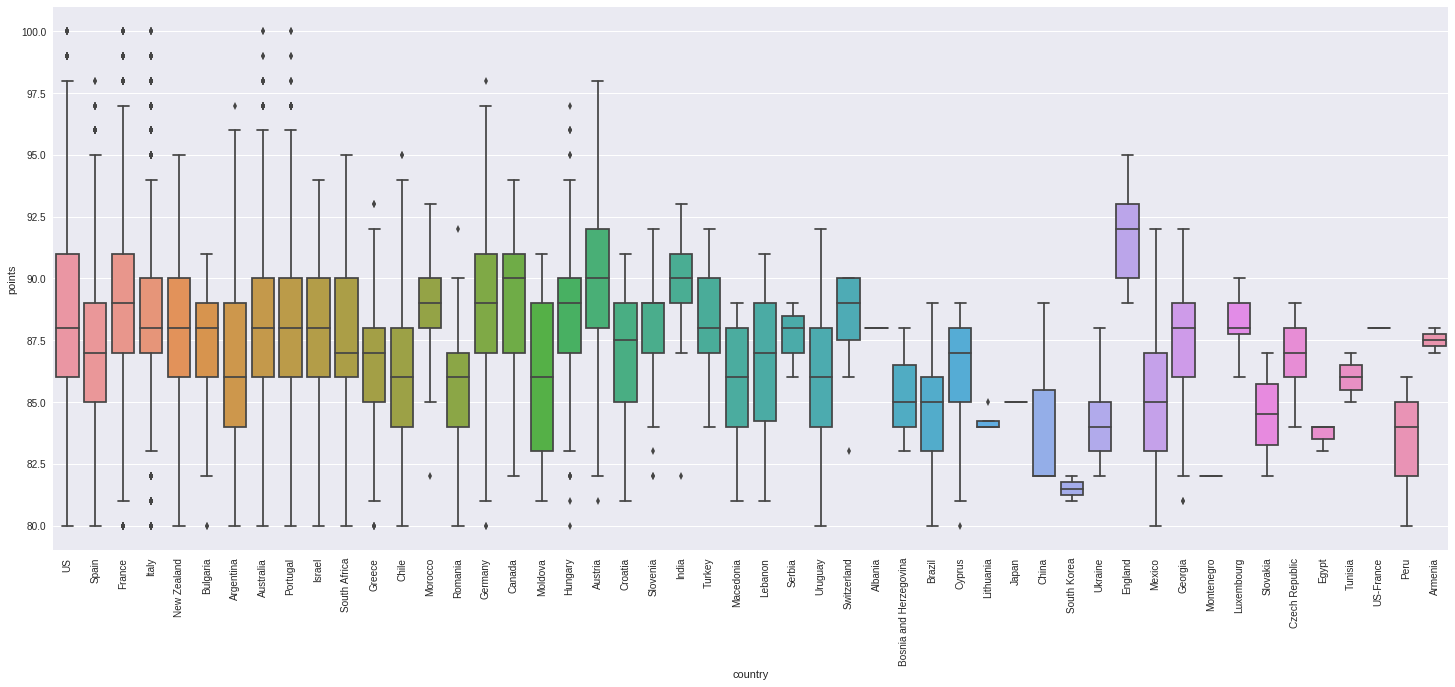

In [415]:
fig, ax = plt.subplots(figsize = (25,10))

chart = sns.boxplot(x='country',y='points', data=wine_reviews, ax = ax)
plt.xticks(rotation = 90)

plt.show()

# Can I Recommend You a Wine?

In [402]:
import unicodedata
from nltk.corpus import stopwords
from string import punctuation
from gensim import corpora, models, similarities

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [44]:
wine_ml = wine_reviews.copy()

We start by fixing some the wine varieties that are in non-english languages.

In [46]:
wine_ml['variety'] = wine_ml['variety'].replace(['weissburgunder'], 'chardonnay') 

wine_ml['variety'] = wine_ml['variety'].replace(['spatburgunder'], 'pinot noir') 

wine_ml['variety'] = wine_ml['variety'].replace(['grauburgunder'], 'pinot gris')

wine_ml['variety'] = wine_ml['variety'].replace(['garnacha'], 'grenache')

wine_ml['variety'] = wine_ml['variety'].replace(['pinot nero'], 'pinot noir')

wine_ml['variety'] = wine_ml['variety'].replace(['alvarinho'], 'albarino')

Next, we will build a corpus of the descriptions and corpora dictionary and doc2bow to turn these into sparse vectors of the number of occurrences of each distinct word, using the word to integer word id  mapping from the corpora dictionary. We can then use the TfidfModel to transform word-document co-occurrence matrix into a global matrix of floats.

In [99]:
wines = wine_reviews.variety.unique().tolist()
stoplist = stopwords.words('english') + list(punctuation) + wines

In [144]:
def build_corpus(col, stoplist):
    corpus = [desc.lower() for desc in col]
    return [[word for word in str(desc).split() if word not in stoplist] for desc in corpus]

In [139]:
len(wine_ml.variety.value_counts()[wine_ml.variety.value_counts() > 500])

43

In [138]:
wine_ml.variety.value_counts()[wine_ml.variety.value_counts() > 500].index.str.contains('Blend').sum()

9

This leaves us with out about 35 plausible topics to model, if our end goals is for this to be somewhat representative of the varieties of wine.

In [145]:
corpus = build_corpus(wine_ml.description, stoplist)

In [146]:
dictionary = corpora.Dictionary(corpus)
corpus = [dictionary.doc2bow(text) for text in texts]

In [147]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
total_topics = 35

Now that we have built a dfidf corpus, we can use Latent Dirichlet Allocation to essneitally bin our words in to topics in a way similar to a probability distribution.

In [148]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

In [167]:
wine_ml_topics = wine_ml[['title', 'variety', 'description', 'points', 'price', 'winery']]

We can now use our LDA model to return the most likely topic for each description in the dataset. This and price will be the values we use to recommend a few wines below.

In [169]:
likely_topics = [max(lda[corpus[row]], key = itemgetter(1))[0] for row in range(wine_ml_topics.shape[0])]

In [171]:
wine_ml_topics = wine_ml_topics.assign(topic = likely_topics)

In [401]:
recommend_df = wine_ml_topics.dropna()

In [399]:
def what_wine_to_drink(desc, price_point, df=recommend_df, num_response=5):
    
    wines = recommend_df.variety.unique().tolist()
    stoplist = stopwords.words('english') + list(punctuation) + wines
    
    #narrow by our price points first
    if isinstance(price_point, (int, float)):
        price_mask = (df.price < price_point+4.5*df.price.std()) & (df.price > price_point-4.5*df.price.std())
        predict_df = df[df.price == price_point]
        price = price_point
    else:
        price_dict = {'wine or pay rent': (3300, 500), 
                      'expensive': (500, 100),
                      'not so expensive': (100,25), 'party': (25,0)}
        
        price_mask = (df.price < price_dict[price_point][0]) & (df.price > price_dict[price_point][1])
        predict_df = df[price_mask]
        #choose average price of category
        price = np.mean(price_dict[price_point])
    
    #get most likely topic
    texts = [word for word in str(description).lower().split() if word not in stoplist]
    desc_v = dictionary.doc2bow(texts)
    topic = max(lda[desc_v], key = itemgetter(1))[0]
    
    predict_df = predict_df[predict_df.topic==topic]
    
    predict_df = predict_df[['price','topic']]
    
    user_wine = np.array([price, topic])
    try:
        predict_df = predict_df.assign(sim_score = cosine_similarity(predict_df, user_wine.reshape(1, -1)))
    except ValueError:
        predict_df = recommend_df[['price','topic']]
        predict_df = predict_df.assign(sim_score = cosine_similarity(predict_df, user_wine.reshape(1, -1)))
       
    return recommend_df.loc[predict_df.nlargest(5, 'sim_score').index].drop('topic', axis=1)

In [397]:
def wine_info():
    desc = input('Enter a short description of what kind of wine you want to drink: \n')
    desc = list(desc)
    
    price_point = input('''Enter a price points of "wine or pay rent", "expensive ", "not so expensive", "party", 
                        or an actual numerical price: \n''')
    if len(price_point) < 5:
        price_point = float(price_point)
    
    return what_wine_to_drink(desc, price_point)    

In [398]:
wine_info()

Enter a short description of what kind of wine you want to drink: 
a fruity tart and beautiful wine with a hint of lemon
Enter a price points of "wine or pay rent", "expensive ", "not so expensive", "party", 
                        or an actual numerical price: 
88


,variety,description,points,price,winery
title,,,,,
Robert Weil 2010 Kiedrich Gräfenberg Erstes Gewächs Trocken Riesling (Rheingau),Riesling,"Voluptuous and almost creamy on the palate, th...",93,88.0,Robert Weil


This kind of works! Playing around with it, it does seem to work better with the lower price point, probably because there are a wider variest of topics in those ranges. Next step would be find a way to test the correctness our recommendations. Ideally, I would use other features to calculate the similarity score, but I'm not super upset with how this is working and it worked pretty quickly.

## Predicting Score

Before I decided to go down the wine recommending path, I started with this Ridge regression of predicting the score from description. I wanted to try and use other features along with description to predict a score, but it got computationally expensive, so I moved on to the simple recommender, which also seemed a little bit more different from thing I've attempted before.

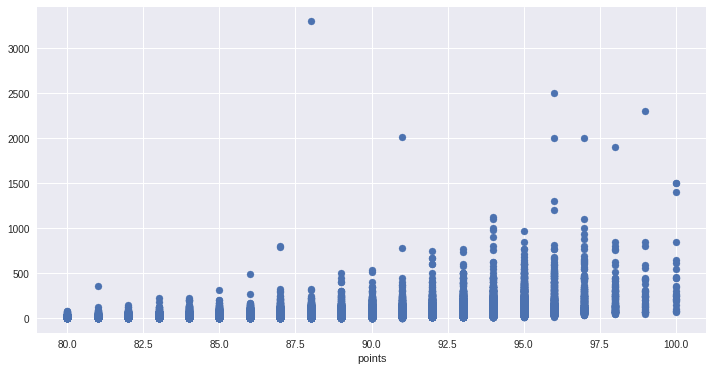

In [416]:
plt.figure(figsize=(12,6))
plt.scatter(wine_reviews.points, wine_reviews.price)
plt.xlabel('points');

In [418]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [419]:
wine_pred_score = wine_reviews.dropna()

In [421]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words = stoplist)

In [423]:
y = wine_pred_score['points']
X = vectorizer.fit_transform(wine_pred_score['description'])

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [427]:
reg = linear_model.Ridge(alpha = 0.5, solver = 'sag').fit(X_train, y_train)

In [429]:
y_pred = reg.predict(X_test)

In [430]:
mean_squared_error(y_test, y_pred)

3.2415951357236437

In [432]:
r2_score(y_test, y_pred)

0.57328366474191361